In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d

PROJECT_DIR = './'

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
        
# Try attaching to GPU
DEVICE = str(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
print('Using:', DEVICE)

Using: cpu


In [2]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d

def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def plot_signals(xs, t, labels=None, args=None, ratio=2.6, do_transform=False, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            # plot the data
            if do_transform:
                assert args is not None, "Need an args object in order to do transforms"
                x, t = transform(x, t, args)  # optionally, transform the signal in some manner
            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 

print("Examples from original MNIST dataset:")
URL = 'https://raw.githubusercontent.com/greydanus/mnist1d/master/static/mnist.png'
Image(url= URL,  width=800)

Examples from original MNIST dataset:


Templates for the MNIST-1D dataset:


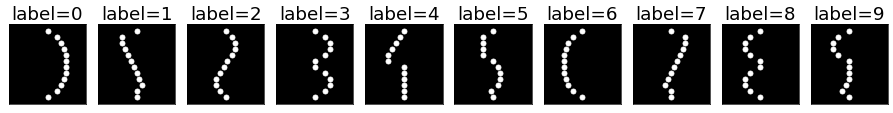

In [4]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=True)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_black.png')

Templates for the MNIST-1D dataset:


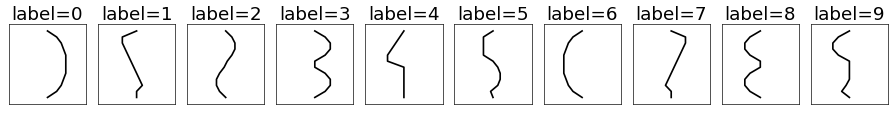

In [5]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_signals(x, t, labels=y, ratio=1.33, dark_mode=False)

# fig.savefig(PROJECT_DIR + 'static/mnist1d_white.png')

In [6]:
# transformations of the templates which will make them harder to fit
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

Defines the constraints that are imposed to generate the new 1D dataset with 500 samples

In [7]:
def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 500,
            'train_split': 1.0,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42}
    return arg_dict if as_dict else ObjectView(arg_dict)

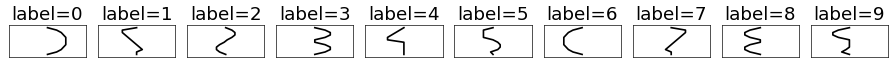

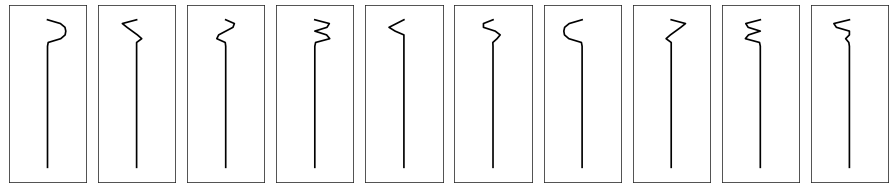

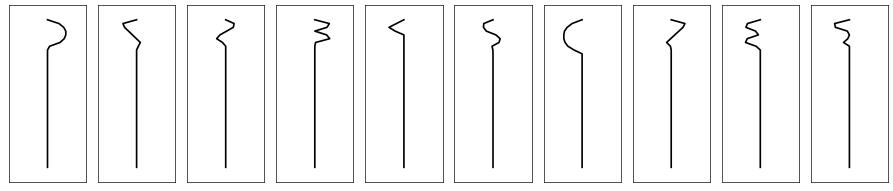

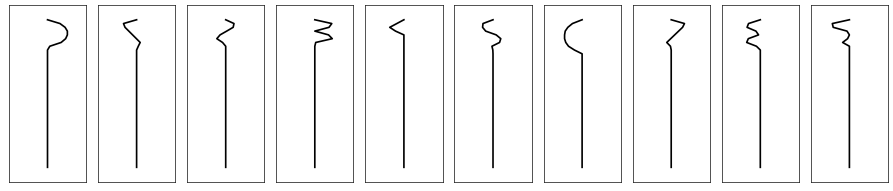

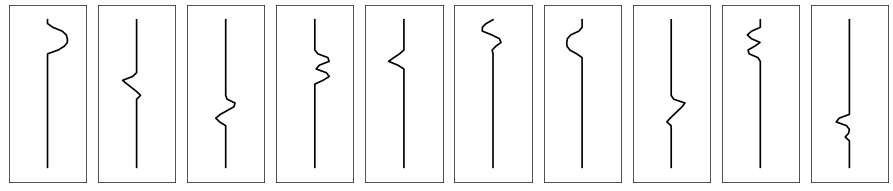

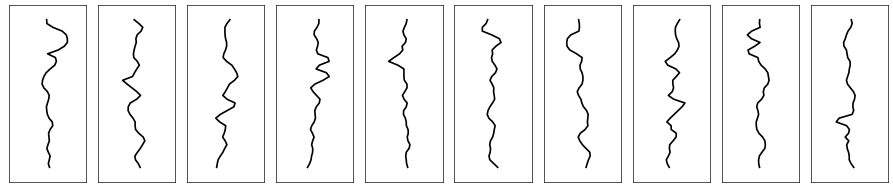

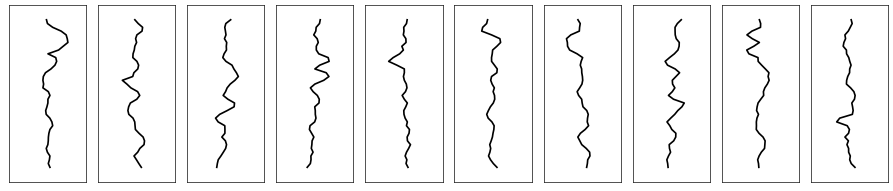

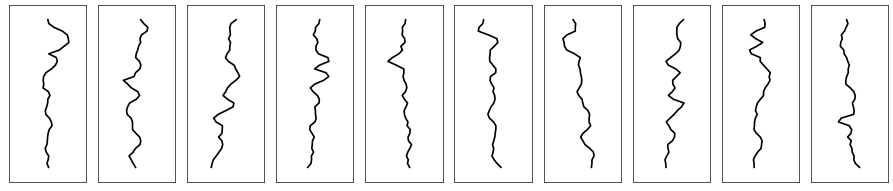

In [8]:
def apply_ablations(arg_dict, n=7):
    ablations = [('shear_scale', 0),
                ('iid_noise_scale', 0),
                ('corr_noise_scale', 0),
                ('max_translation', 1),
                ('scale_coeff', 0),
                ('padding', [arg_dict['padding'][-1], arg_dict['padding'][-1]]),
                ('padding', [0, 0]),]
    num_ablations = min(n, len(ablations))
    for i in range(num_ablations):
        k, v = ablations[i]
        arg_dict[k] = v
    return arg_dict

templates = get_templates()
for i, n in enumerate(reversed(range(8))):
    np.random.seed(0)
    arg_dict = get_dataset_args(as_dict=True)
    arg_dict = apply_ablations(arg_dict, n=n)
    args = ObjectView(arg_dict)
    do_transform = args.padding[0] != 0
    fig = plot_signals(templates['x'], templates['t'], labels=None if do_transform else templates['y'],
                 args=args, ratio=2.2 if do_transform else 0.8,
                 do_transform=do_transform)
#     fig.savefig(PROJECT_DIR + 'static/transform_{}.png'.format(i))

Create MNIST 1D dataset with 500 samples.

In [9]:
def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [10]:
args = get_dataset_args()
set_seed(args.seed)
args.shuffle_seq = False
data = make_dataset(args=args)  # make the dataset

set_seed(args.seed)
args.shuffle_seq = True
data_shuff = make_dataset(args=args)  # make the dataset, shuffling the spatial dimension

print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))
print("Number of classes: {}".format(len(data['templates']['y'])))

Examples in training set: 500
Examples in test set: 0
Length of each example: 40
Number of classes: 10


For each class, we took 50 samples

In [11]:
import pandas as pd
block_data = data
index=pd.Series(data['y'])
print(index.value_counts())

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64


Normalizing the data to have unit length

In [12]:
dataX=data['x']
dataY=data['y']

for i in range(len(dataX)):
  l_i=np.linalg.norm(dataX[i],axis=0,keepdims=True)
  dataX[i]=dataX[i]/l_i

data_dup = data
data_dup['x'] = dataX
print(dataX)

[[ 0.23767531  0.29452095  0.30312649 ... -0.06882125 -0.18715362
  -0.35629644]
 [ 0.05071572 -0.00851993 -0.0320768  ...  0.2059266   0.32847684
   0.35159448]
 [-0.02762388 -0.03142066  0.01530829 ... -0.18281484 -0.32146664
  -0.34109639]
 ...
 [ 0.19589856  0.24863771  0.19032554 ... -0.16094414 -0.18536381
  -0.24581798]
 [-0.20060064 -0.14727106 -0.1482583  ...  0.08849051  0.12395196
   0.05779548]
 [ 0.19735903  0.0900937   0.03875271 ... -0.11493005 -0.12303779
  -0.14562619]]


H-infinity matrix: Determines convergency rate

In [13]:
import math
from numpy.linalg import eig

x=dataX
x_T= np.transpose(x)

k=np.dot(x,x_T)

# H_infi is a Gram matrix induced by relu activation function and random initialization
angle=np.arccos(np.dot(x,x_T))
angle=np.nan_to_num(angle)
angle=(math.pi-angle)/math.pi

H=np.multiply(k,angle)
print(H)

w,v=eig(H)
np.min(w)
# No two inputs are parallel as minimum Eigen value is strictly positive

[[ 1.         -0.08811088  0.12194199 ...  0.52026979 -0.05502125
   0.43171197]
 [-0.08811088  1.         -0.17554571 ... -0.05216117  0.1274322
  -0.06479419]
 [ 0.12194199 -0.17554571  0.99999999 ...  0.05455642 -0.10823101
   0.17711542]
 ...
 [ 0.52026979 -0.05216117  0.05455642 ...  1.         -0.10078718
   0.52583538]
 [-0.05502125  0.1274322  -0.10823101 ... -0.10078718  0.99999999
  -0.14412373]
 [ 0.43171197 -0.06479419  0.17711542 ...  0.52583538 -0.14412373
   1.        ]]


C:\Users\shrav\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in arccos
  # Remove the CWD from sys.path while we load stuff.


0.1098407036715986

Input layer neurons are 40

Hidden layer neurons are 1000

Output layer neurons are 10

Therefore total parameters are (40*1000)+1000+(10*1000)+10 = 51010 parameters (which is much greater than 500)

For 1000 hidden node shallow neural network with ReLU activation and 500 training data, as no of parameters is large enough and no two inputs are parallel, randomly initialized gradient descent converges to a globally optimal solution at a linear convergence rate for the quadratic loss function.

In [14]:
from scipy.ndimage.measurements import minimum
from mnist1d.models import ConvBase, MLPBase, LinearBase, GRUBase
from mnist1d.train import get_model_args, train_model

Changes in model.py class:

We intialize weights as Normal Distribution (wr ~ N(0,I))
    nn.init.normal_(self.linear1.weight, mean=0, std=1)
As theorem states ar ~ unif[{-1,1}] 
    nn.init.uniform_(self.linear1.weight, -1, 1)

40
10
1000
Initialized MLPBase model with 51010 parameters
one hot encoding done
step 1, dt 0.01s, train_loss 1.563e-01, train_acc 8.4
step 1000, dt 4.52s, train_loss 6.673e-02, train_acc 59.0
step 2000, dt 12.28s, train_loss 5.785e-02, train_acc 73.2
step 3000, dt 11.04s, train_loss 5.234e-02, train_acc 78.0
step 4000, dt 4.09s, train_loss 4.832e-02, train_acc 83.8
step 5000, dt 4.50s, train_loss 4.516e-02, train_acc 89.8
step 6000, dt 4.39s, train_loss 4.255e-02, train_acc 91.8
step 7000, dt 4.21s, train_loss 4.032e-02, train_acc 93.6
step 8000, dt 4.13s, train_loss 3.839e-02, train_acc 94.8
step 9000, dt 4.13s, train_loss 3.668e-02, train_acc 95.6
step 10000, dt 4.12s, train_loss 3.514e-02, train_acc 96.6
10001



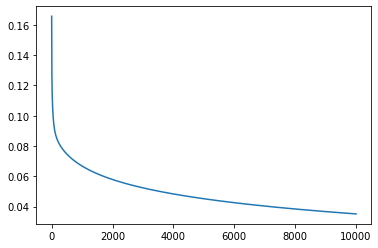

In [15]:
args = get_model_args()
args.total_steps = 10000
args.hidden_size = 1000
args.device = DEVICE

set_seed(args.seed)
print(args.input_size)
print(args.output_size)
print(args.hidden_size)

model = MLPBase(args.input_size, args.output_size)
results_mlp = train_model(data_dup, model, args)

trainloss=results_mlp['train_losses']
print(len(trainloss))
print()

import matplotlib.pyplot as plt

x=[i for i in range(10001)]
plt.plot(x,trainloss)
plt.show()

The loss function is exponentially decaying
||u(t) - y|| ≤ exp(−λ0t) ||u(0) − y||

By the end of stage wise training, the training loss is almost equal to previous training loss.
However the training loss is minimum in the initial steps.

Initialized MLPBase model with 51010 parameters
(50, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.513e-01, train_acc 4.0
step 1000, dt 0.75s, train_loss 8.920e-04, train_acc 100.0
1001


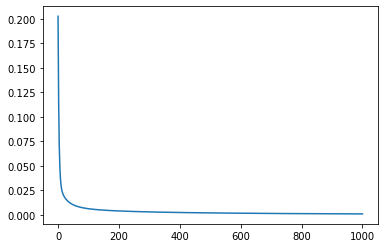

Initialized MLPBase model with 51010 parameters
(100, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.464e-01, train_acc 14.0
step 1000, dt 0.89s, train_loss 4.850e-03, train_acc 100.0
step 2000, dt 0.87s, train_loss 2.764e-03, train_acc 100.0
2001


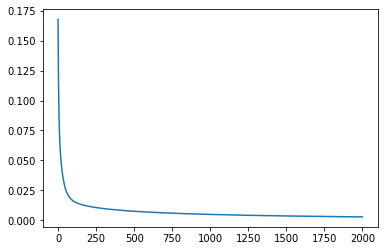

Initialized MLPBase model with 51010 parameters
(150, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.266e-01, train_acc 14.0
step 1000, dt 0.96s, train_loss 1.787e-02, train_acc 92.0
step 2000, dt 0.95s, train_loss 5.973e-03, train_acc 96.0
step 3000, dt 0.96s, train_loss 1.094e-02, train_acc 97.3
3001


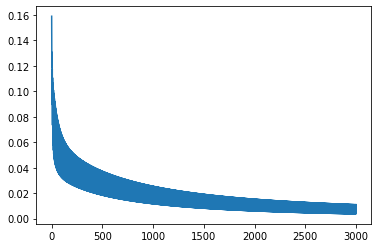

Initialized MLPBase model with 51010 parameters
(200, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.552e-01, train_acc 10.0
step 1000, dt 1.18s, train_loss 3.930e-02, train_acc 78.5
step 2000, dt 1.17s, train_loss 2.794e-02, train_acc 88.5
step 3000, dt 1.17s, train_loss 2.183e-02, train_acc 93.5
step 4000, dt 1.17s, train_loss 1.790e-02, train_acc 95.0
4001


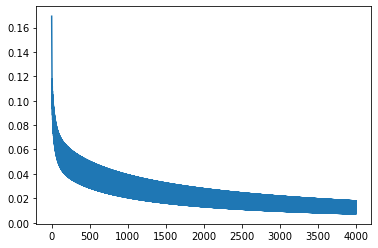

Initialized MLPBase model with 51010 parameters
(250, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.514e-01, train_acc 12.4
step 1000, dt 1.67s, train_loss 4.291e-02, train_acc 80.8
step 2000, dt 1.67s, train_loss 3.270e-02, train_acc 89.2
step 3000, dt 1.65s, train_loss 2.684e-02, train_acc 94.0
step 4000, dt 1.68s, train_loss 2.286e-02, train_acc 98.4
step 5000, dt 1.68s, train_loss 1.992e-02, train_acc 99.2
5001


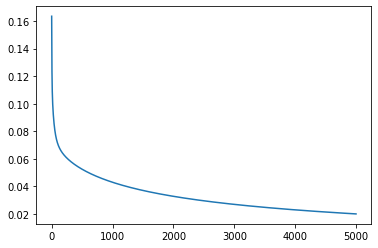

Initialized MLPBase model with 51010 parameters
(300, 40)
one hot encoding done
step 1, dt 0.00s, train_loss 1.347e-01, train_acc 11.3
step 1000, dt 1.75s, train_loss 3.383e-02, train_acc 55.0
step 2000, dt 1.76s, train_loss 3.591e-02, train_acc 68.3
step 3000, dt 2.08s, train_loss 4.547e-02, train_acc 76.0
step 4000, dt 2.03s, train_loss 1.641e-02, train_acc 78.3
step 5000, dt 2.08s, train_loss 2.264e-02, train_acc 81.0
step 6000, dt 2.00s, train_loss 3.435e-02, train_acc 83.3
6001


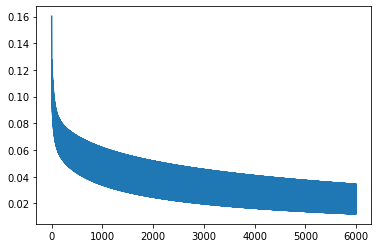

Initialized MLPBase model with 51010 parameters
(350, 40)
one hot encoding done
step 1, dt 0.01s, train_loss 1.500e-01, train_acc 10.0
step 1000, dt 1.98s, train_loss 4.020e-02, train_acc 48.0
step 2000, dt 1.82s, train_loss 5.217e-02, train_acc 55.1
step 3000, dt 1.76s, train_loss 1.601e-02, train_acc 58.6
step 4000, dt 1.84s, train_loss 3.179e-02, train_acc 62.6
step 5000, dt 1.94s, train_loss 5.919e-03, train_acc 65.4
step 6000, dt 1.92s, train_loss 1.843e-02, train_acc 69.4
step 7000, dt 1.77s, train_loss 4.276e-02, train_acc 72.0
7001


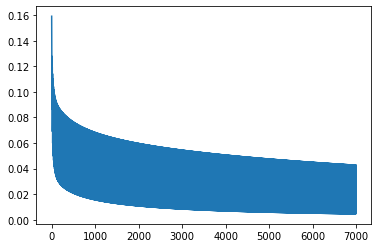

Initialized MLPBase model with 51010 parameters
(400, 40)
one hot encoding done
step 1, dt 0.01s, train_loss 1.522e-01, train_acc 8.8
step 1000, dt 2.18s, train_loss 7.090e-02, train_acc 44.5
step 2000, dt 2.18s, train_loss 6.166e-02, train_acc 55.8
step 3000, dt 2.18s, train_loss 5.603e-02, train_acc 63.2
step 4000, dt 2.30s, train_loss 5.193e-02, train_acc 68.2
step 5000, dt 2.28s, train_loss 4.869e-02, train_acc 72.0
step 6000, dt 3.63s, train_loss 4.601e-02, train_acc 73.5
step 7000, dt 6.47s, train_loss 4.372e-02, train_acc 76.8
step 8000, dt 6.55s, train_loss 4.172e-02, train_acc 79.2
8001


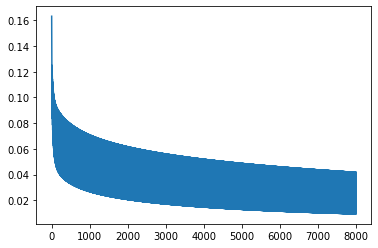

Initialized MLPBase model with 51010 parameters
(450, 40)
one hot encoding done
step 1, dt 0.03s, train_loss 1.482e-01, train_acc 9.1
step 1000, dt 3.31s, train_loss 7.176e-02, train_acc 40.0
step 2000, dt 2.25s, train_loss 5.430e-02, train_acc 50.9
step 3000, dt 2.25s, train_loss 4.060e-02, train_acc 57.6
step 4000, dt 2.24s, train_loss 3.349e-02, train_acc 62.0
step 5000, dt 2.23s, train_loss 2.337e-02, train_acc 64.0
step 6000, dt 2.25s, train_loss 1.555e-02, train_acc 65.3
step 7000, dt 2.22s, train_loss 1.034e-02, train_acc 66.4
step 8000, dt 2.22s, train_loss 5.259e-03, train_acc 68.2
step 9000, dt 2.23s, train_loss 4.857e-02, train_acc 70.4
9001


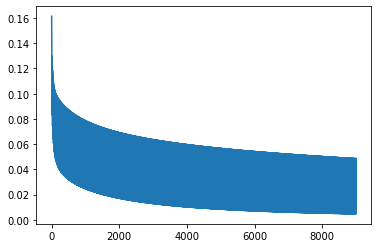

Initialized MLPBase model with 51010 parameters
(500, 40)
one hot encoding done
step 1, dt 0.01s, train_loss 1.563e-01, train_acc 8.4
step 1000, dt 4.20s, train_loss 6.673e-02, train_acc 59.0
step 2000, dt 4.18s, train_loss 5.785e-02, train_acc 73.2
step 3000, dt 4.18s, train_loss 5.234e-02, train_acc 78.0
step 4000, dt 4.24s, train_loss 4.832e-02, train_acc 83.8
step 5000, dt 4.19s, train_loss 4.516e-02, train_acc 89.8
step 6000, dt 4.19s, train_loss 4.255e-02, train_acc 91.8
step 7000, dt 4.19s, train_loss 4.032e-02, train_acc 93.6
step 8000, dt 4.20s, train_loss 3.839e-02, train_acc 94.8
step 9000, dt 4.18s, train_loss 3.668e-02, train_acc 95.6
step 10000, dt 4.22s, train_loss 3.514e-02, train_acc 96.6
10001


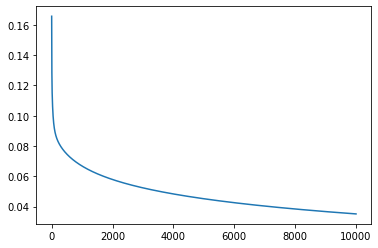

In [16]:
import matplotlib.pyplot as plt

inputList=[]
pred=[]
stepsize=0
for i in range(10):
  for x,y in zip(dataX,dataY):
    if i==y:
      inputList.append(x)
      pred.append(y)
    inputX=np.array(inputList)
    outputY= np.array(pred)
    block_data['x'] = inputX
    block_data['y'] = outputY
  stepsize+=1000

  args = get_model_args()
  args.total_steps = stepsize
  args.device = DEVICE

  set_seed(args.seed)
  model = MLPBase(args.input_size, args.output_size)
  print(block_data['x'].shape)
  results_mlp = train_model(block_data, model, args)

  trainloss=results_mlp['train_losses']
  print(len(trainloss))
  xaxis=[i for i in range(stepsize+1)]
  plt.plot(xaxis,trainloss)
  plt.show()

Hij (0) = 1/m (xi xj) Σ (r=1 to m) I(xi*wr(0) ≥ 0, xj*wr(0) ≥ 0)

In [17]:
#H_0 calculation
weights = model.linear1.weight.detach().numpy()
print(weights.shape)
def indicator_h(x_i,x_j,w_r):
  if np.dot(x_i.T,w_r) >= 0 and np.dot(x_j.T,w_r) >=0:
    return 1
  return 0

# H_0=np.array([[0 for j in range(500)] for i in range(500)])
H_0=np.random.randn(500,500)
for i in range(500):
  for j in range(500):
    s=0
    for m in range(1000):
      s+=indicator_h(dataX[i,:],dataX[j,:], weights[m,:])
    H_0[i][j]=((np.dot(dataX[i,:].T,dataX[j,:]))*s)/1000

w,v=eig(H_0)
print(np.min(w))

(1000, 40)
0.046202283148125044
